In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class ModelTrainer:
    def __init__(self, model, train_dataset, test_dataset, device, learning_rate=0.01, lambda_l2=0.0001, num_epochs=40):
        self.model = model.to(device)
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        self.test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
        self.device = device
        self.learning_rate = learning_rate
        self.lambda_l2 = lambda_l2
        self.num_epochs = num_epochs
        self.y_true = []
        self.y_pred = []
        self.criterion = nn.CrossEntropyLoss()
        
    def train_manual(self):
        """Train the model manually without using an optimizer."""
        self.model.train()
        for epoch in range(self.num_epochs):
            running_loss = 0.0
            for images, labels in self.train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                l2_reg = 0
                for param in self.model.parameters():
                    l2_reg += torch.sum(param ** 2)
                loss += self.lambda_l2 * l2_reg

                self.model.zero_grad()
                loss.backward()
                with torch.no_grad():
                    for param in self.model.parameters():
                        param -= self.learning_rate * param.grad

                running_loss += loss.item()

            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Loss: {running_loss / len(self.train_loader):.4f}')

    def train_with_optimizer(self, optimizer):
        """Train the model using an optimizer."""
        self.model.train()
        for epoch in range(self.num_epochs):
            running_loss = 0.0
            for images, labels in self.train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Loss: {running_loss / len(self.train_loader):.4f}')

    def evaluate(self):
        """Evaluate the model on the test dataset."""
        self.model.eval()
        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                self.y_true.extend(labels.cpu().numpy())
                self.y_pred.extend(predicted.cpu().numpy())
        print(classification_report(self.y_true, self.y_pred, target_names=self.train_dataset.classes))



    def plot_confusion_matrix(self, model_name="Model"):
        """Plot the confusion matrix for the model's predictions."""

        conf_matrix = confusion_matrix(self.y_true, self.y_pred)
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=self.train_dataset.classes, yticklabels=self.train_dataset.classes)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f"Confusion Matrix for Fashion-MNIST Classification for {model_name}")
        plt.show()
        conf_matrix[range(len(conf_matrix)), range(len(conf_matrix))] = 0
        most_confused = np.unravel_index(conf_matrix.argmax(), conf_matrix.shape)
        print(f'Two classes most confused with each other: {self.train_dataset.classes[most_confused[0]]} and {self.train_dataset.classes[most_confused[1]]}')


    def plot_weight_histograms(self, model_name="Model"):
        """Plot histograms of the model's layer weights."""

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.hist(self.model.fc1.weight.detach().cpu().numpy().flatten(), bins=50)
        plt.title(f"{model_name} - Input Layer Weights")

        plt.subplot(1, 2, 2)
        plt.hist(self.model.fc2.weight.detach().cpu().numpy().flatten(), bins=50)
        plt.title(f"{model_name} - Hidden Layer Weights")

        plt.show()


In [4]:
transform = transforms.Compose([transforms.ToTensor(),])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# Q1.1

In [5]:
class FashionMNISTNet(nn.Module):
    def __init__(self):
        super(FashionMNISTNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
model_trainer = ModelTrainer(FashionMNISTNet(), train_dataset, test_dataset, device, learning_rate=0.01, lambda_l2=0.0001, num_epochs=20)

In [7]:
model_trainer.train_manual()

Epoch [1/20], Loss: 1.2388
Epoch [2/20], Loss: 0.7679
Epoch [3/20], Loss: 0.6665
Epoch [4/20], Loss: 0.6115
Epoch [5/20], Loss: 0.5724
Epoch [6/20], Loss: 0.5452
Epoch [7/20], Loss: 0.5250
Epoch [8/20], Loss: 0.5081
Epoch [9/20], Loss: 0.4941
Epoch [10/20], Loss: 0.4825
Epoch [11/20], Loss: 0.4740
Epoch [12/20], Loss: 0.4658
Epoch [13/20], Loss: 0.4592
Epoch [14/20], Loss: 0.4520
Epoch [15/20], Loss: 0.4459
Epoch [16/20], Loss: 0.4397
Epoch [17/20], Loss: 0.4341
Epoch [18/20], Loss: 0.4301
Epoch [19/20], Loss: 0.4273
Epoch [20/20], Loss: 0.4221


In [8]:
model_trainer.evaluate()

              precision    recall  f1-score   support

 T-shirt/top       0.80      0.84      0.82      1000
     Trouser       0.98      0.95      0.97      1000
    Pullover       0.76      0.73      0.75      1000
       Dress       0.84      0.87      0.86      1000
        Coat       0.72      0.81      0.76      1000
      Sandal       0.95      0.92      0.94      1000
       Shirt       0.68      0.56      0.61      1000
     Sneaker       0.91      0.93      0.92      1000
         Bag       0.93      0.96      0.95      1000
  Ankle boot       0.93      0.95      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



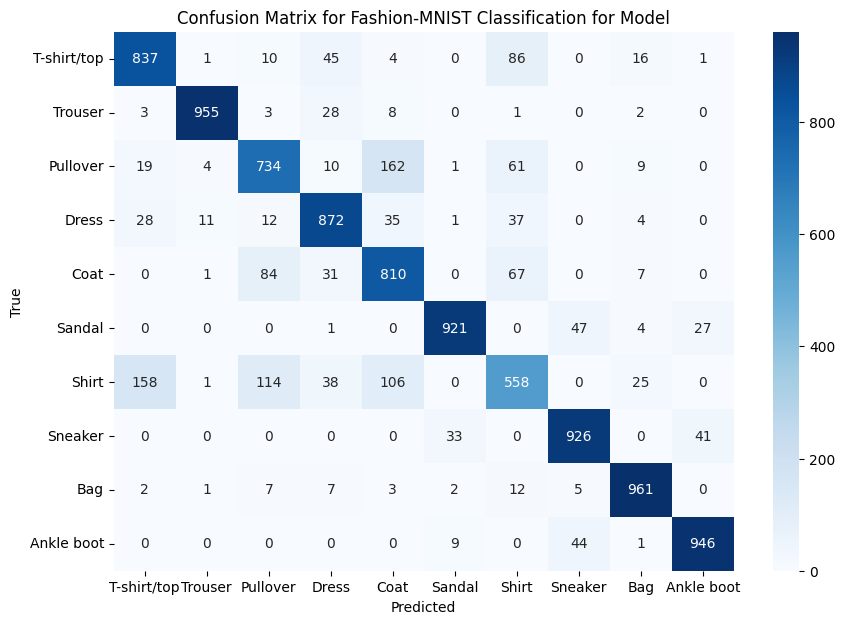

Two classes most confused with each other: Pullover and Coat


In [9]:
model_trainer.plot_confusion_matrix()

# Q1.2

In [10]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.fc1 = nn.Linear(28*28, 48)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(48, 10)      

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [11]:
model_trainer1 = ModelTrainer(Model1(), train_dataset, test_dataset, device, learning_rate=0.01, lambda_l2=0.0001, num_epochs=40)
model_trainer2 = ModelTrainer(Model2(), train_dataset, test_dataset, device, learning_rate=0.01, lambda_l2=0.0001, num_epochs=40)

In [12]:
model_trainer1.train_manual()
print("\n\n First model is trained\n\n")
model_trainer2.train_manual()
print("\n\n Second model is trained")

Epoch [1/40], Loss: 1.1327
Epoch [2/40], Loss: 0.6710
Epoch [3/40], Loss: 0.5788
Epoch [4/40], Loss: 0.5342
Epoch [5/40], Loss: 0.5068
Epoch [6/40], Loss: 0.4889
Epoch [7/40], Loss: 0.4750
Epoch [8/40], Loss: 0.4646
Epoch [9/40], Loss: 0.4556
Epoch [10/40], Loss: 0.4484
Epoch [11/40], Loss: 0.4414
Epoch [12/40], Loss: 0.4353
Epoch [13/40], Loss: 0.4290
Epoch [14/40], Loss: 0.4243
Epoch [15/40], Loss: 0.4189
Epoch [16/40], Loss: 0.4140
Epoch [17/40], Loss: 0.4096
Epoch [18/40], Loss: 0.4053
Epoch [19/40], Loss: 0.4021
Epoch [20/40], Loss: 0.3986
Epoch [21/40], Loss: 0.3946
Epoch [22/40], Loss: 0.3914
Epoch [23/40], Loss: 0.3882
Epoch [24/40], Loss: 0.3853
Epoch [25/40], Loss: 0.3818
Epoch [26/40], Loss: 0.3796
Epoch [27/40], Loss: 0.3766
Epoch [28/40], Loss: 0.3734
Epoch [29/40], Loss: 0.3713
Epoch [30/40], Loss: 0.3684
Epoch [31/40], Loss: 0.3668
Epoch [32/40], Loss: 0.3640
Epoch [33/40], Loss: 0.3616
Epoch [34/40], Loss: 0.3597
Epoch [35/40], Loss: 0.3577
Epoch [36/40], Loss: 0.3554
E

In [13]:
model_trainer1.evaluate()
model_trainer2.evaluate()

              precision    recall  f1-score   support

 T-shirt/top       0.81      0.83      0.82      1000
     Trouser       0.99      0.96      0.97      1000
    Pullover       0.78      0.77      0.77      1000
       Dress       0.84      0.88      0.86      1000
        Coat       0.78      0.80      0.79      1000
      Sandal       0.96      0.93      0.95      1000
       Shirt       0.68      0.64      0.66      1000
     Sneaker       0.92      0.94      0.93      1000
         Bag       0.95      0.95      0.95      1000
  Ankle boot       0.94      0.95      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.83      0.83      1000
     Trouser       0.99      0.96      0.97      1000
    Pullover       0.76      0.76      0.76      1000
       Dress       0.85 

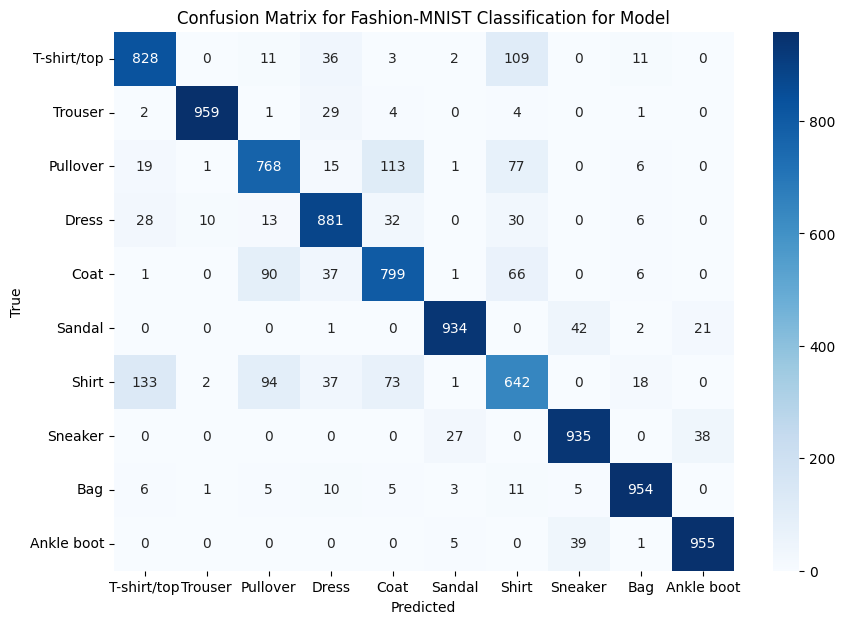

Two classes most confused with each other: Shirt and T-shirt/top


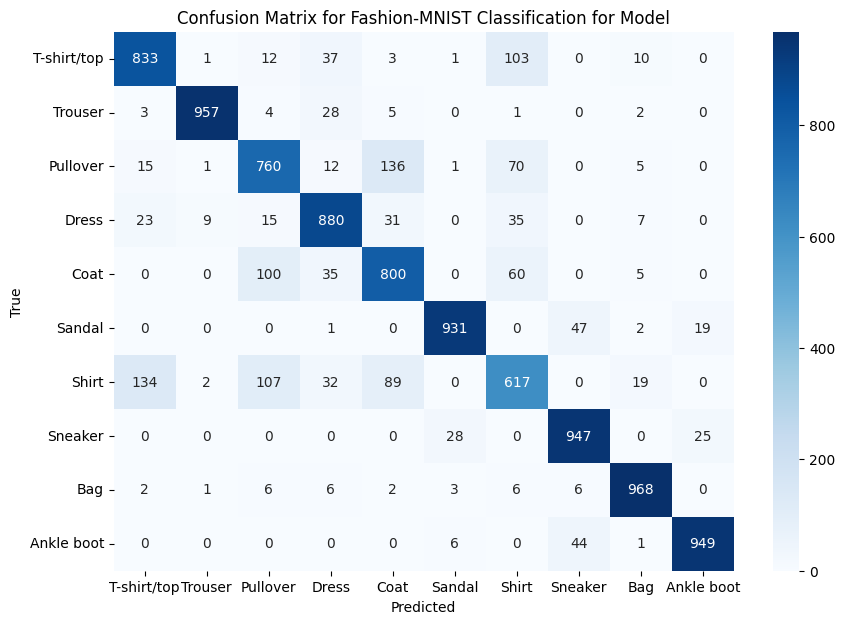

Two classes most confused with each other: Pullover and Coat


In [14]:
model_trainer1.plot_confusion_matrix()
model_trainer2.plot_confusion_matrix()

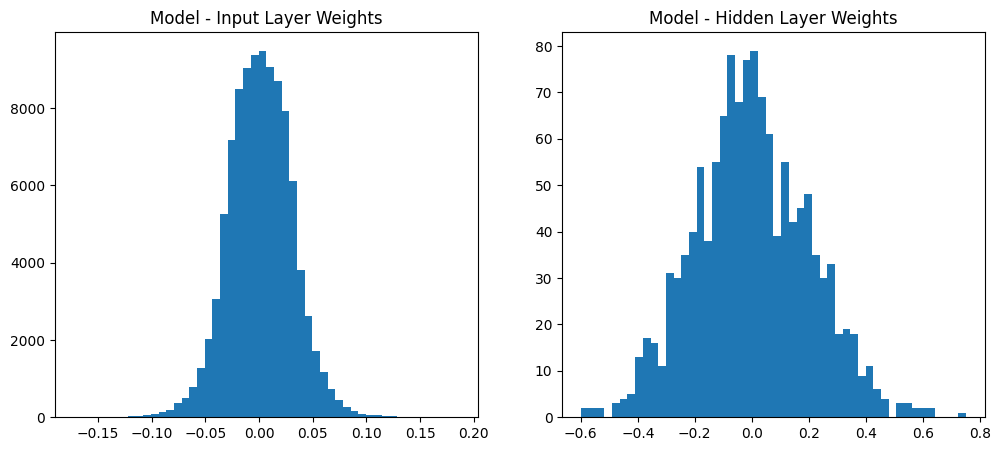

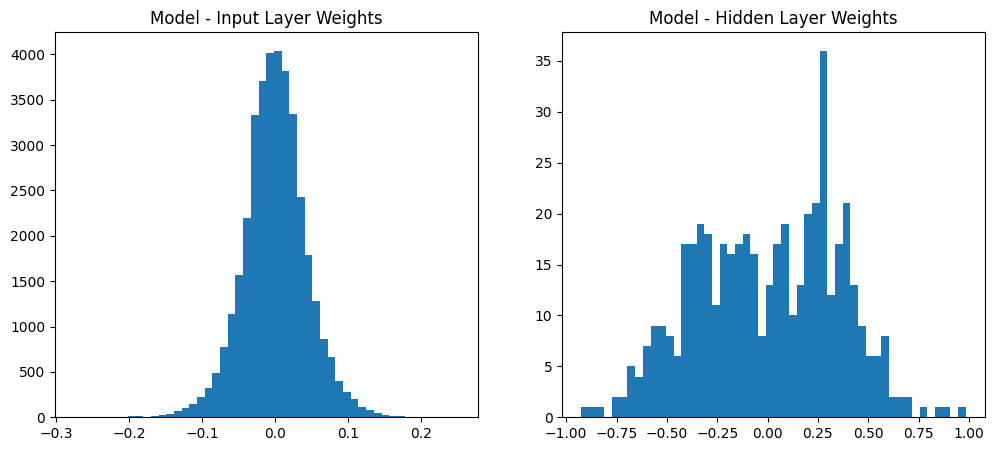

In [15]:
model_trainer1.plot_weight_histograms()
model_trainer2.plot_weight_histograms()